In [9]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras_preprocessing.image import ImageDataGenerator


from ml.eval import eval_model
from ml.pipeline import FeitDataPipeline
from tensorflow import keras

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import schedules
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import concatenate

from cfg import *

from livelossplot import PlotLossesKerasTF

print(os.getcwd())
os.chdir('/home/jelinek/recetox/')

name = "MySimpleCnn_Feit-reduced-rgb-no-inception-different-neighbourhood"


/home/jelinek/recetox


In [10]:
class MySimpleCNNInceptionModule(FeitDataPipeline):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.model = self.get_compiled_model()
        self.params.name = name
        self.params.epochs = 200
        self.batch_size = 16
        self.params.tile_size=256
        self.params.number_of_classes = 12
        self.params.latent_representation_size = 12


    @staticmethod
    def get_compiled_model():
        inputs = keras.Input(shape=(256, 256, 3))

        x = keras.layers.Conv2D(filters=16, kernel_size=5, strides=(1, 1), padding='same')(inputs)

        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Conv2D(filters=32, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)


        x = keras.layers.Conv2D(filters=64, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Conv2D(filters=128, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Conv2D(filters=256, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)


        x = keras.layers.Conv2D(filters=512, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Flatten()(x)
        outputs = keras.layers.Dense(units=12, activation='softmax')(x)

        model = keras.Model(inputs, outputs, name='MySimpleCnnFewerLayers')
        model.summary()
        return model

    def get_data_loader_training(self):
        datagen_train = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, samplewise_center=True,
                                           samplewise_std_normalization=True)

        return datagen_train.flow_from_directory(directory=self.params.data_training, color_mode='rgb',
                                                 class_mode='categorical', batch_size=self.params.batch_size,
                                                 shuffle=True,
                                                 target_size=(self.params.tile_size, self.params.tile_size))

    def get_data_loader_validation(self):
        datagen_valid = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)
        return datagen_valid.flow_from_directory(directory=self.params.data_validation, color_mode='rgb',
                                                 class_mode='categorical', batch_size=self.params.batch_size,
                                                 shuffle=False,
                                                 target_size=(self.params.tile_size, self.params.tile_size))


    def _train_model(self, data_train, data_valid):

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                      patience=30, min_lr=1e-4, verbose=1,
                                      cooldown=20)

        self.model.fit(data_train,
                       steps_per_epoch=250,
                       epochs=200,
                       shuffle=True,
                       validation_data=data_valid,
                       validation_freq=10,
                       verbose=1,
                       callbacks=[self.tensorboard, reduce_lr, PlotLossesKerasTF()])

In [11]:
pipeline = MySimpleCNNInceptionModule(train_data_dir='data/Feit_colon-annotation-tiles-256/data_train/',
                        valid_data_dir='data/Feit_colon-annotation-tiles-256/data_valid/')

Model: "MySimpleCnnFewerLayers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 256, 256, 16)      1216      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 32)      12832     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 64, 64, 

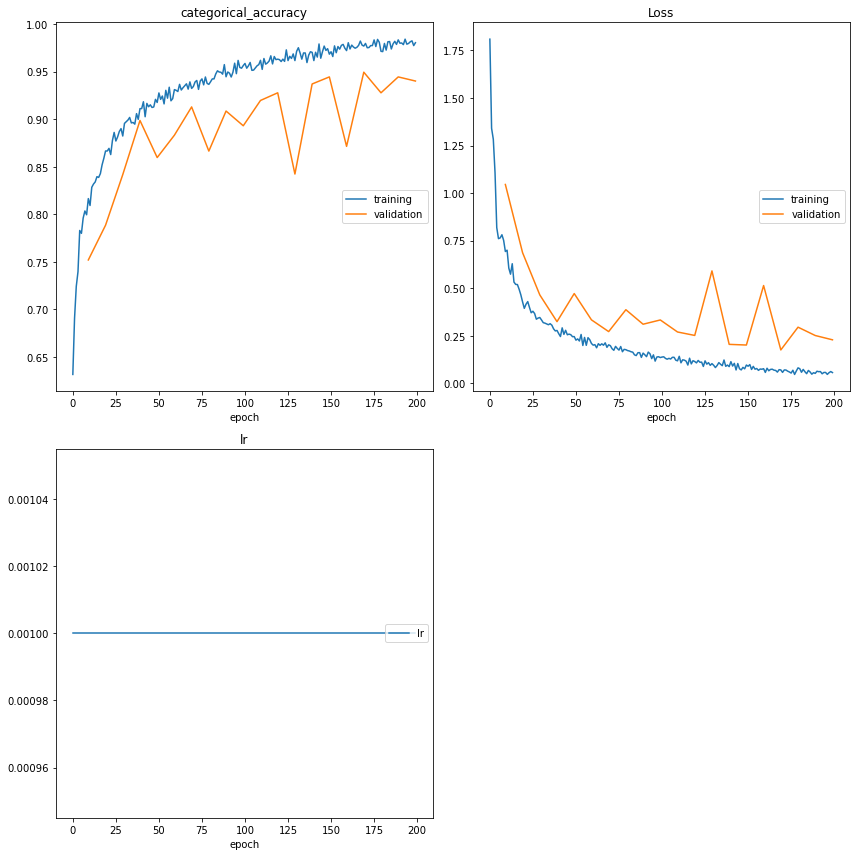

categorical_accuracy
	training         	 (min:    0.632, max:    0.984, cur:    0.980)
	validation       	 (min:    0.752, max:    0.949, cur:    0.940)
Loss
	training         	 (min:    0.047, max:    1.809, cur:    0.057)
	validation       	 (min:    0.176, max:    1.045, cur:    0.229)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
10/10 [==============================] - 1s 54ms/step - loss: 0.0800 - categorical_accuracy: 0.9625
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.3947ms
Confusion Matrix
[[326   0   1   0   2   0   1   0   0   0   3   2]
 [  1  44   8   1   0   0   6   4   0   0   0   0]
 [  1   9 120   0   2   0   5   6   0   0   2   0]
 [  0   0   0  10   1   0   0   0   0   0   0   0]
 [  0   0   3   1 539   0   0   0   0   0   1   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0]
 [  0   1   0   0   0   0  73   3   0   0   0   0]
 [  0   1   1   0   0   0   4  80   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0   

In [12]:
pipeline.execute_pipeline(perform_validation=True, perform_test_segmentation=False)

In [13]:
pipeline.save_pipeline()

In [14]:
eval_model(pipeline.model,
           pipeline.get_data_loader_validation(),
           name,
           print_confusion_matrix=True,
           save_misclassified=True)

Found 1617 images belonging to 12 classes.
10/10 [==============================] - 1s 54ms/step - loss: 0.0800 - categorical_accuracy: 0.9625
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.3955ms
Confusion Matrix
[[326   0   1   0   2   0   1   0   0   0   3   2]
 [  1  44   8   1   0   0   6   4   0   0   0   0]
 [  1   9 120   0   2   0   5   6   0   0   2   0]
 [  0   0   0  10   1   0   0   0   0   0   0   0]
 [  0   0   3   1 539   0   0   0   0   0   1   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0]
 [  0   1   0   0   0   0  73   3   0   0   0   0]
 [  0   1   1   0   0   0   4  80   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0   0   0]
 [  0   0   0   0   1   0   0   0   0   0   0   0]
 [ 19   1   0   0   1   0   0   1   0   0 211   1]
 [  2   0   0   0   0   0   0   0   0   0   0 116]]
Classification Report
                             precision    recall  f1-score   support

             adenocarcinoma       0.93      0.97      0.95 

In [15]:
pipeline = FeitDataPipeline.load_pipeline(pipeline_name=name)

In [16]:
from ml.eval import evaluate_segmentation_on_feit_annotation

evaluation_path = Path('data/Feit_colon-annotation_valid/')

segmentation_dir = Path('segmentations') / pipeline.params.name

evaluate_segmentation_on_feit_annotation(evaluation_path, pipeline.build_segmenter(),
                                         32, pipeline.params.class_names,
                                         save_segmentations=True, segmentations_dir=segmentation_dir,
                                         neighbourhood_size=0)

Processing region 120 out of 120
Processing image took 1839.6662385463715 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-reduced-rgb-no-inception-different-neighbourhood/ns-adenoca-colon-15071-2019-20x-he-4.tiff
Processing region 255 out of 255
Processing image took 4415.394505023956 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-reduced-rgb-no-inception-different-neighbourhood/ns-adenoca-colon-15072-2019-20x-he-a2.tiff
Processing region 255 out of 255
Processing image took 4257.638679742813 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-reduced-rgb-no-inception-different-neighbourhood/ns-adenoca-colon-3043-2019-20x-he-a1.tiff
Processing region 567 out of 567
Processing image took 9673.991230249405 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-reduced-rgb-no-inception-different-neighbourhood/pop-ca-colon-1708-2019-5-20x-he.tiff
[[423730   5907   9478    244   2273     13   1136   4437      3      0
   

In [17]:
from ml.eval import evaluate_segmentation_on_feit_annotation

evaluation_path = Path('data/Feit_colon-annotation_valid/')

segmentation_dir = Path('segmentations') / pipeline.params.name

evaluate_segmentation_on_feit_annotation(evaluation_path, pipeline.build_segmenter(),
                                         32, pipeline.params.class_names,
                                         save_segmentations=True, segmentations_dir=segmentation_dir,
                                         neighbourhood_size=1)

Processing region 120 out of 120
Processing image took 1858.6434519290924 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-reduced-rgb-no-inception-different-neighbourhood/ns-adenoca-colon-15071-2019-20x-he-4.tiff
Processing region 255 out of 255
Processing image took 4426.317299604416 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-reduced-rgb-no-inception-different-neighbourhood/ns-adenoca-colon-15072-2019-20x-he-a2.tiff
Processing region 255 out of 255
Processing image took 4266.866996526718 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-reduced-rgb-no-inception-different-neighbourhood/ns-adenoca-colon-3043-2019-20x-he-a1.tiff
Processing region 567 out of 567
Processing image took 9705.808732032776 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-reduced-rgb-no-inception-different-neighbourhood/pop-ca-colon-1708-2019-5-20x-he.tiff
[[468757   4593   3752     65    509      0    130   2520      0      0
   

In [18]:
from ml.eval import evaluate_segmentation_on_feit_annotation

evaluation_path = Path('data/Feit_colon-annotation_valid/')

segmentation_dir = Path('segmentations') / pipeline.params.name

evaluate_segmentation_on_feit_annotation(evaluation_path, pipeline.build_segmenter(),
                                         32, pipeline.params.class_names,
                                         save_segmentations=True, segmentations_dir=segmentation_dir,
                                         neighbourhood_size=3)

Processing region 120 out of 120
Processing image took 1858.14719247818 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-reduced-rgb-no-inception-different-neighbourhood/ns-adenoca-colon-15071-2019-20x-he-4.tiff
Processing region 255 out of 255
Processing image took 4489.981570005417 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-reduced-rgb-no-inception-different-neighbourhood/ns-adenoca-colon-15072-2019-20x-he-a2.tiff
Processing region 255 out of 255
Processing image took 4452.695838928223 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-reduced-rgb-no-inception-different-neighbourhood/ns-adenoca-colon-3043-2019-20x-he-a1.tiff
Processing region 567 out of 567
Processing image took 10065.388505220413 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-reduced-rgb-no-inception-different-neighbourhood/pop-ca-colon-1708-2019-5-20x-he.tiff
[[475195   4464   9836    508    439      0    495   2753      0      0
   3

In [19]:
from ml.eval import evaluate_segmentation_on_feit_annotation

evaluation_path = Path('data/Feit_colon-annotation_valid/')

segmentation_dir = Path('segmentations') / pipeline.params.name

evaluate_segmentation_on_feit_annotation(evaluation_path, pipeline.build_segmenter(),
                                         32, pipeline.params.class_names,
                                         save_segmentations=True, segmentations_dir=segmentation_dir,
                                         neighbourhood_size=5)

Processing region 120 out of 120
Processing image took 1972.3568127155304 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-reduced-rgb-no-inception-different-neighbourhood/ns-adenoca-colon-15071-2019-20x-he-4.tiff
Processing region 255 out of 255
Processing image took 4851.948832273483 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-reduced-rgb-no-inception-different-neighbourhood/ns-adenoca-colon-15072-2019-20x-he-a2.tiff
Processing region 255 out of 255
Processing image took 5018.098630666733 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-reduced-rgb-no-inception-different-neighbourhood/ns-adenoca-colon-3043-2019-20x-he-a1.tiff
Processing region 567 out of 567
Processing image took 10542.759328603745 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-reduced-rgb-no-inception-different-neighbourhood/pop-ca-colon-1708-2019-5-20x-he.tiff
[[465339   4415  23887    563    464      0    999   2940      0      0
  